In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## 1. Data Exploration & Preprocessing

In [37]:
train_path = "../data/seg_train"
test_path  = "../data/seg_test"

IMG_SIZE = (150, 150)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [39]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 6 classes.


In [42]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)


In [40]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Training set class distribution:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


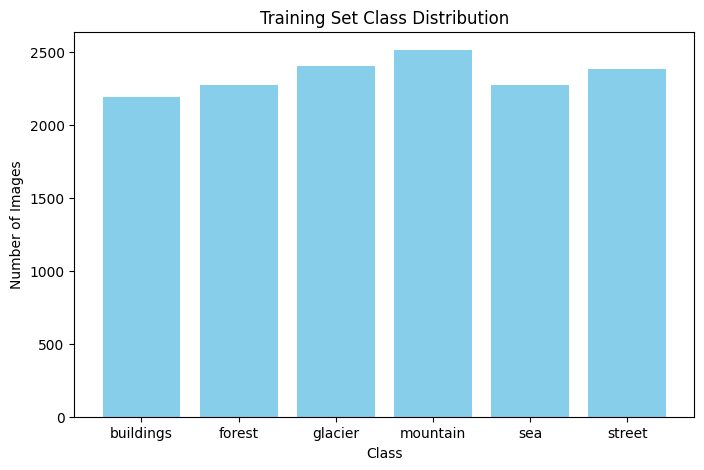

In [41]:
class_names = sorted(os.listdir(train_path))

# Count images per class
train_counts = {}
for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)
    train_counts[class_name] = len(os.listdir(class_folder))

# Print counts
print("Training set class distribution:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")
    
plt.figure(figsize=(8,5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [35]:
from PIL import Image

img_shapes = []
corrupted_images = []

for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        try:
            with Image.open(img_path) as img:
                img_shapes.append(img.size)  # (width, height)
        except:
            corrupted_images.append(img_path)

print("Number of images checked:", len(img_shapes))
print("Unique image sizes:", set(img_shapes))
print("Number of corrupted images:", len(corrupted_images))

Number of images checked: 14034
Unique image sizes: {(150, 136), (150, 81), (150, 145), (150, 142), (150, 105), (150, 102), (150, 108), (150, 111), (150, 120), (150, 123), (150, 135), (150, 141), (150, 144), (150, 150), (150, 147), (150, 110), (150, 113), (150, 119), (150, 131), (150, 76), (150, 134), (150, 140), (150, 143), (150, 146), (150, 149), (150, 100), (150, 97), (150, 103), (150, 115), (150, 124), (150, 133)}
Number of corrupted images: 0


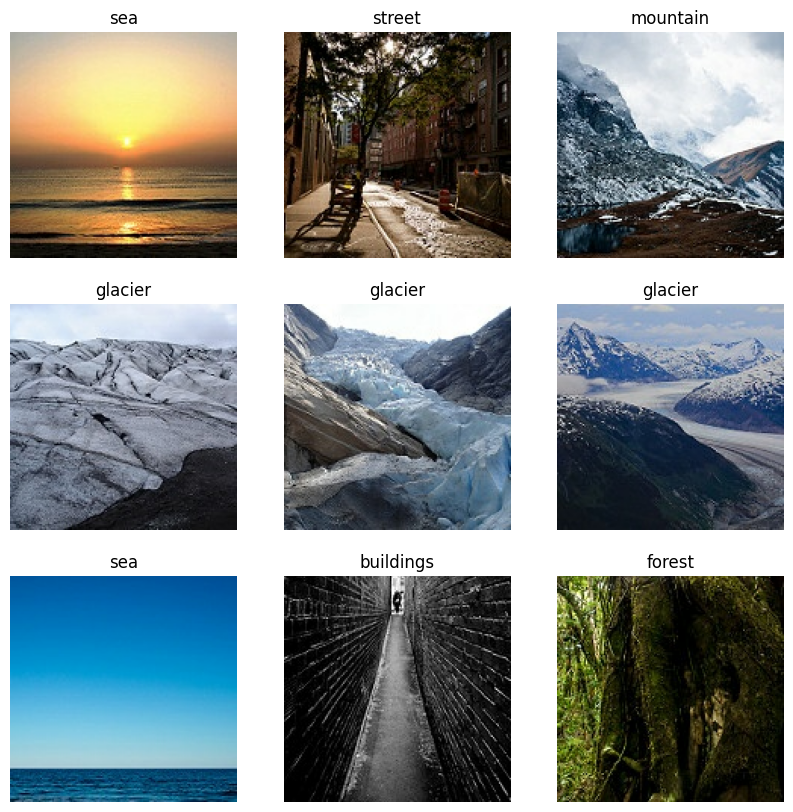

In [36]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 2. Baseline CNN (No Augmentation)

In [45]:
num_classes = len(class_names)  # 6 classes

model_basic = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten + Dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # multi-class
])

model_basic.summary()


c:\Users\jchen\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)